## Examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SCS-KDE library
from scskde import SCSKDE

### Get daily weather data and preprocess
Use Meteostat library to download some station data:

In [2]:
from datetime import datetime
from meteostat import Point, Daily

# Set time period
start = datetime(1980, 1, 1)
end = datetime(2023, 12, 31)

# Create Point for London City Airport
lat, lon = 51.505, 0.046
location = Point(lat, lon)#, 70)

# Get daily data
data = Daily(location, start, end)
data = data.fetch()

Check for nulls

In [3]:
data[data[['tmin','tmax']].isnull().any(axis=1)]

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1980-08-23,12.9,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-06-02,14.2,NaN,18.1,6.1,NaN,NaN,NaN,NaN,NaN,NaN
1985-02-23,4.4,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-12-16,4.6,NaN,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2007-03-07,8.5,NaN,12.7,0.8,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-28,16.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-29,16.6,NaN,21.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Sufficiently few NaNs to justify forward-filling for this example.

In [4]:
X_hist = data[['tmin','tmax']].ffill()

Experience suggests that the data may be heteroskedastic; stabilise variance by shifting and log-transforming:

In [5]:
def trans(X):
    shift = X.min().abs() + 0.1
    return np.log(X + shift), shift

In [6]:
X_hist_tr, shift = trans(X_hist)

We know there's seasonality in this data, so define periods by month and tag each day:

In [7]:
periods_hist = X_hist.index.month.values
periods_hist

array([ 1,  1,  1, ..., 12, 12, 12], dtype=int32)

Calculate empirical CDFs by month for comparison with the simulated versions later:

In [8]:
total_days_per_month_hist = X_hist.index.month.value_counts()[periods_hist].values
total_days_per_month_hist

array([1364, 1364, 1364, ..., 1364, 1364, 1364])

In [9]:
ecdf_hist = X_hist.groupby(periods_hist).rank(method='max').div(total_days_per_month_hist, axis=0)
ecdf_hist.head()

,tmin,tmax
time,,
1980-01-01,0.012463,0.031525
1980-01-02,0.009531,0.057185
1980-01-03,0.009531,0.578446
1980-01-04,0.567449,0.797654
1980-01-05,0.357038,0.468475


### Fit model

Define model order (maximum number of lags) and dependencies - both variables are endogenous, so just depend on themselves and the other one.

In [10]:
ordern = 3
depn = {(m, n): list(range(2)) for m in range(1, 13) for n in range(2)}
depn

{(1, 0): [0, 1],
 (1, 1): [0, 1],
 (2, 0): [0, 1],
 (2, 1): [0, 1],
 (3, 0): [0, 1],
 (3, 1): [0, 1],
 (4, 0): [0, 1],
 (4, 1): [0, 1],
 (5, 0): [0, 1],
 (5, 1): [0, 1],
 (6, 0): [0, 1],
 (6, 1): [0, 1],
 (7, 0): [0, 1],
 (7, 1): [0, 1],
 (8, 0): [0, 1],
 (8, 1): [0, 1],
 (9, 0): [0, 1],
 (9, 1): [0, 1],
 (10, 0): [0, 1],
 (10, 1): [0, 1],
 (11, 0): [0, 1],
 (11, 1): [0, 1],
 (12, 0): [0, 1],
 (12, 1): [0, 1]}

In [11]:
model = SCSKDE(ordern=ordern)

In [12]:
model.fit(X_hist_tr.values, depn, periods=periods_hist)

  0%|          | 0/24 [00:00<?, ?it/s]

### Simulate from model

Define periods array:

In [13]:
N_years = 100
months = np.arange(1, 13)
days_per_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
periods_stoc = np.repeat(np.repeat(months, days_per_month)[None,:], N_years, axis=0).ravel()
print(periods_stoc.size)
periods_stoc

36500


array([ 1,  1,  1, ..., 12, 12, 12])

Define initial values:

In [14]:
X0 = X_hist_tr.values[:ordern][None]

Simulate:

In [15]:
X_stoc = pd.DataFrame(model.simulate(periods_stoc.size, X0=X0, periods=periods_stoc)[0], columns=X_hist.columns)
X_stoc = np.exp(X_stoc) - shift
X_stoc.head(5)

  0%|          | 0/36497 [00:00<?, ?it/s]

,tmin,tmax
0,-5.000000,1.000000
1,-6.000000,2.000000
2,-6.000000,9.000000
3,2.696804,11.556099
4,3.359886,9.162113


Calculate empirical CDFs by month for comparison with the historic versions:

In [16]:
total_days_per_month_stoc = np.bincount(periods_stoc)[1:][periods_stoc-1]
total_days_per_month_stoc

array([3100, 3100, 3100, ..., 3100, 3100, 3100])

In [17]:
ecdf_stoc = X_stoc.groupby(periods_stoc).rank(method='max').div(total_days_per_month_stoc, axis=0)
ecdf_stoc.head()

,tmin,tmax
0,0.003548,0.006452
1,0.001613,0.020323
2,0.001613,0.547419
3,0.364516,0.780000
4,0.443226,0.558387


### Compare empirical CDFs from historic and stochastic data

In [18]:
m = 12
mask_hist = periods_hist==m
mask_stoc = periods_stoc==m

In [19]:
ecdf_tmin_hist = pd.DataFrame({'tmin': X_hist['tmin'][mask_hist],
                               'ecdf': ecdf_hist['tmin'][mask_hist]}).sort_values('tmin')
ecdf_tmax_hist = pd.DataFrame({'tmax': X_hist['tmax'][mask_hist],
                               'ecdf': ecdf_hist['tmax'][mask_hist]}).sort_values('tmax')

ecdf_tmin_stoc = pd.DataFrame({'tmin': X_stoc['tmin'][mask_stoc], 
                               'ecdf': ecdf_stoc['tmin'][mask_stoc]}).sort_values('tmin')
ecdf_tmax_stoc = pd.DataFrame({'tmax': X_stoc['tmax'][mask_stoc], 
                               'ecdf': ecdf_stoc['tmax'][mask_stoc]}).sort_values('tmax')

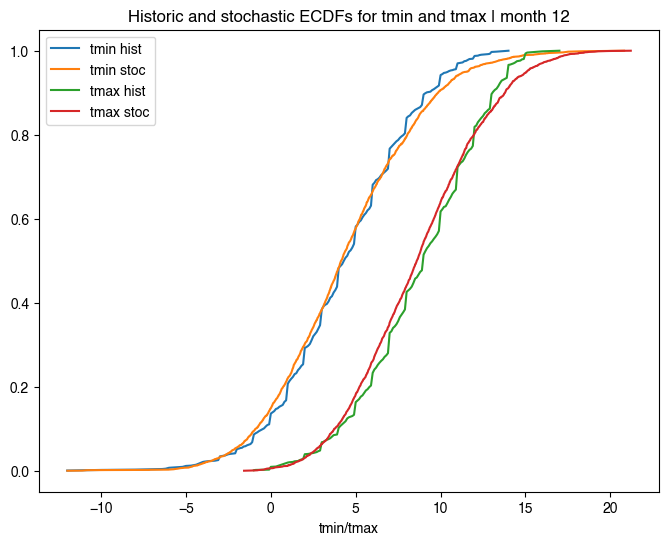

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ecdf_tmin_hist.plot('tmin', 'ecdf', label='tmin hist', ax=ax)
ecdf_tmin_stoc.plot('tmin', 'ecdf', label='tmin stoc', ax=ax)
ecdf_tmax_hist.plot('tmax', 'ecdf', label='tmax hist', ax=ax)
ecdf_tmax_stoc.plot('tmax', 'ecdf', label='tmax stoc', ax=ax)
ax.set_xlabel('tmin/tmax')
ax.set_title(f'Historic and stochastic ECDFs for tmin and tmax | month {m}');